# Coursework 1 - This needs a proper title

## I. Background

- Why this study is of interest and relevant

## II. Study Purpose

### A. Motivation and Objectives

### B. Research Questions

In [1]:
# import libraries
import pandas as pd
import requests
import datetime
from bs4 import BeautifulSoup
import fasttext
from IPython.display import Markdown as md
import seaborn as sns

### C. Limitations

- Describe limitations, only hellopeter, but there are many other sources of social media like facebook and twitter. 
- Predominantly complaints
- Specific to telecoms in south africa, similar techniques will be applicable to other industries.
- why the dataset is appropriate

## II. Research Methodology

- Describe that the study will be primary a NLP project and this is why the NLP preparation to follow.

### A. Data Source

- Describe why Hellopeter 
- A good explanation as to why this data source has been selected.
- Justify that this is a major source of reviews/complaints which the telecoms actively monitor and respond to. Note that Telkom issued a notice (https://www.hellopeter.com/telkom) that they are phasing it out and urge customers to contact them via twitter opr facebook.
- Bellow implement the class to load data from Hellopeter via api


The logic for retrieving review data from Hellopeter.com is encapsulated in the class below. This allows this class to be moved to a separate .py file to enable re-use and to ensure that activities specifically related to the inner workings of the API have a layer of abstraction should the API change at a future date.

In [2]:
class Hellopeter():
    """
    This class is used to retrieve Hellopeter reviews via the `https://api.hellopeter.com/consumer/business/` API.

    Parameters
    ----------
    business : str
        The business name to retrieve reviews for.
    api_url : str
        The base URL used to invoke the Hellopeter API.
    """
    def __init__(self, business:str, api_url:str='https://api.hellopeter.com/consumer/business/') -> None:
        self.business = business
        self.api_url = api_url
        self.url_template = self.api_url + self.business + '/reviews?page='

        # initialize the session to use for requests to the API
        self.request_session = requests.Session()

    def request_page(self, page_number:int) -> dict:
        """
        Request a specific review page for the business.

        Parameters
        ----------
        page_number : int
            The page number to retrieve the reviews from.   

        Returns
        -------
        response_json : dict
        """
        # set the full url for the request
        url = self.url_template + str(page_number)
       
        # set the request headers
        headers = {
            'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
            'accept': 'application/json'
        }

        # request the review page
        respose = self.request_session.get(url=url)

        # implement basic error handling
        if respose.status_code == 202:
            return respose.json()
        else:
            raise Exception('An unexpected response code were received: %s' % respose.status_code)

    def process_request_page(self, page_json:dict) -> pd.DataFrame:
        """
        Process the raw JSON data of a review page and convert it to a Pandas DataFrame.

        Parameters
        ----------
        page_json : dict
            The raw JSON (represented as a Python dictionary) that was retrieved from the API.

        Returns
        -------
        page_data : pandas.DataFrame
            The page data converted to a DataFrame.            
        """
        # create the dataframe
        page_data = pd.DataFrame(page_json['data'])

        # add the business name to the dataframe
        page_data['business'] = self.business

        # basic data type conversions
        page_data.created_at = pd.to_datetime(page_data.created_at)
        page_data.replied = page_data.replied.astype('bool')        

        # return the processed page data
        return page_data

    def retrieve_reviews(self, stop_at:datetime) -> pd.DataFrame:
        """
        Retrieve reviews for the business up to, and including the `stop_at` date.

        Parameters
        ----------
        stop_at : datetime
            The date of the last review to retrieve.

        Returns
        -------
        review_data : pandas.DataFrame
            A DataFrame containing the reviews retrieved.            
        """
        page_data = pd.DataFrame()
        current_page = 1
        stop_retrieval = False

        while not stop_retrieval:
            # retrieve the reviews for the current page
            current_reviews = self.process_request_page(self.request_page(current_page))

            # add the current page to the output dataframe
            page_data = pd.concat([page_data, current_reviews])

            # increment the page counter
            current_page += 1

            # determine if data retrieval should be stopped
            #print(current_reviews.created_at.min(), stop_at)
            stop_retrieval = current_reviews.created_at.min() < stop_at

            # print a progress indicator
            if current_page % 100 == 0:
                print(current_page, current_reviews.created_at.min())

        # perform the final filter for the stop date
        page_data = page_data.query('created_at >= @stop_at')

        # return the result dataframe
        return page_data

In [10]:
def retrieve_bussiness_reviews(business:str, stop_at:datetime, output_path='data/raw/') -> pd.DataFrame:
    """
    Retrieve reviews for a business and store the output in Parquet format.

    Parameters
    ----------
    business : str
        The business name to retrieve reviews for.        
    stop_at : datetime
        The date of the last review to retrieve.    

    Returns
    -------
    review_data : pandas.DataFrame
        A DataFrame containing the reviews retrieved.     
    """
    # retrieve the reviews
    peter = Hellopeter(business)
    review_data = peter.retrieve_reviews(stop_at)

    # save the dataset
    review_data.to_parquet('data/raw/%s.gzip' % business.replace('-', '_'), 
        compression='gzip', index=False)

    # return the retrieved data for futher processing
    return review_data

### B. Ethics of Use

- mention public api
- mention that data are automatically anonymized by hellopeter, but businesses still have access to the full details.

 It should be noted that data retrieval can be dramatically improved by using parallel processing with multiple concurrent requests to the Hellopeter API. However, optimization of data retrieval was explicitly excluded due to ethical considerations. Parallel data retrieval techniques will place a significant load on the API, which is to be avoided as it might cause degradation of this service and could potentially have a financial impact as it might cause the Hellopeter infrastructure to unnecessarily scale out due to the sharp increase.

 ### C. Data Retrieval

 - In this section also describe provider selection (telkom, vodacom, cell c, mtn) and why these major ones only.
 - in a separate cell use class and save all data to csv

> ❗Please do not execute the cells below unless new data is required, retrieving the data is a long running operation. The reviews retrieved on `2021/12/21` can be found in Parquet format on [GitHub](https://github.com/JohnnyFoulds/dsm020-2021-oct/tree/master/coursework_01/data/raw).

In [5]:
# retrieve the vodacom dataset
vodacom_reviews = retrieve_bussiness_reviews(business='vodacom', stop_at=datetime.datetime(2021, 1, 1))

100 2021-11-23 23:32:28
200 2021-10-25 13:00:10
300 2021-09-26 07:29:06
400 2021-08-20 14:14:37
500 2021-07-14 19:24:18
600 2021-06-10 23:32:14
700 2021-05-12 13:09:30
800 2021-04-14 11:59:03
900 2021-03-18 09:51:51
1000 2021-02-24 12:43:47
1100 2021-02-03 08:25:32
1200 2021-01-11 08:52:58


In [8]:
# retrieve the mtn dataset
mtn_reviews = retrieve_bussiness_reviews(business='mtn', stop_at=datetime.datetime(2021, 1, 1))

100 2021-11-04 07:36:03
200 2021-09-07 19:31:11
300 2021-07-19 18:42:15
400 2021-05-22 11:36:27
500 2021-03-31 18:42:26
600 2021-02-17 20:04:42
700 2021-01-12 16:14:18


In [9]:
# retrieve the telkom dataset
telkom_reviews = retrieve_bussiness_reviews(business='telkom', stop_at=datetime.datetime(2021, 1, 1))

100 2021-10-23 20:34:44
200 2021-08-24 09:35:28
300 2021-06-26 04:53:36
400 2021-05-04 23:19:26
500 2021-03-15 20:57:52
600 2021-02-04 16:39:07


In [11]:
# retrieve the cell-c dataset
cell_c_reviews = retrieve_bussiness_reviews(business='cell-c', stop_at=datetime.datetime(2021, 1, 1))

100 2021-10-12 14:28:40
200 2021-08-12 07:52:06
300 2021-06-03 18:50:40
400 2021-03-20 14:21:45
500 2021-01-21 12:52:35


 ## III. Data Selection

  - in a separate cell discuss the features that will be selected, then in the next cell drop columns not of interest.

> ℹ️ Data is loaded from the GitHub repository instead of from the locally saved files. This is under the assumption that this notebook will be submitted as a coursework piece with a size limitation on submission size.

In [2]:
# load the raw datasets retrieved fom hellopeter
vodacom_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/raw/vodacom.gzip')
mtn_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/raw/mtn.gzip')
telkom_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/raw/telkom.gzip')
cell_c_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/raw/cell_c.gzip')

### A. Combine Datasets

Combine the datasets into a single DataFrame. This is useful for preparing the data as a whole and performing analysis across the different telecommunications providers.

In [3]:
df_reviews = pd.concat([vodacom_reviews, mtn_reviews, telkom_reviews, cell_c_reviews])
df_reviews.reset_index(inplace=True, drop=True)
df_reviews.shape

(35132, 28)

Get a basic overview of the dataset to assist in selection of the columns of interest.

In [4]:
# get a basic summary of the dataset
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35132 entries, 0 to 35131
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          35132 non-null  int64         
 1   user_id                     35132 non-null  object        
 2   created_at                  35132 non-null  datetime64[ns]
 3   authorDisplayName           35132 non-null  object        
 4   author                      35132 non-null  object        
 5   authorAvatar                35132 non-null  object        
 6   author_id                   35132 non-null  object        
 7   review_title                35132 non-null  object        
 8   review_rating               35132 non-null  int64         
 9   review_content              35132 non-null  object        
 10  business_name               35132 non-null  object        
 11  business_slug               35132 non-null  object    

In [5]:
# convert author_created_date to the datetime type
df_reviews.author_created_date = pd.to_datetime(df_reviews.author_created_date)

# convert the id to string
df_reviews['id'] = df_reviews['id'].astype('str')

In [6]:
# get a sample of the data
df_reviews.sample(n=5, random_state=118)

,id,user_id,created_at,authorDisplayName,author,authorAvatar,author_id,review_title,review_rating,review_content,...,industry_slug,status_id,nps_rating,source,is_reported,business_reporting,author_created_date,author_total_reviews_count,attachments,business
5051,3578165,f66d3530-322e-11ea-b378-9d9b42609b27,2021-07-31 08:49:35,Brian R,Brian R,,f66d3530-322e-11ea-b378-9d9b42609b27,VODACOM FIBRE UNHELPFULL,1,SR**********96 Fibre's been offline for a week...,...,telecommunications,1,NaN,WEBSITE,False,None,2020-01-08,2,[],vodacom
4856,3584982,fe6410e0-8f4c-11e9-98c7-c365b64ec7b8,2021-08-05 19:03:48,Mahomed M,Mahomed M,,fe6410e0-8f4c-11e9-98c7-c365b64ec7b8,Faulty vodacom application,2,When paying on application R559 July tariff th...,...,telecommunications,1,NaN,WEBSITE,False,None,2019-06-15,135,[],vodacom
21780,3745879,be2bf020-51e5-11e8-8a73-dbe5d90e7d04,2021-12-17 12:36:43,Rofhiwa T,Rofhiwa T,,be2bf020-51e5-11e8-8a73-dbe5d90e7d04,Fibre connection,1,If it was possible to give telkom a minus rati...,...,telecommunications,1,NaN,WEBSITE,False,None,2018-05-07,6,[],telkom
34613,3373141,1b4039b3-31fa-11e8-83f4-f23c91bb6188,2021-02-01 09:47:13,Wynand,Wynand,,1b4039b3-31fa-11e8-83f4-f23c91bb6188,Cell C so disappointing....,1,I have a data contract with Cell C - never mis...,...,telecommunications,1,NaN,WEBSITE,False,None,2014-06-02,5,[],cell-c
5118,3574981,0ce8b5d2-31fa-11e8-83f4-f23c91bb6188,2021-07-28 15:04:40,Steven,Steven,,0ce8b5d2-31fa-11e8-83f4-f23c91bb6188,Should be ashamed to call yourself a telecoms ...,1,Someone contact me on ********** I have brough...,...,telecommunications,1,NaN,WEBSITE,False,None,2012-08-31,2,[],vodacom


> ℹ️ When 10 rows were retrieved using the same seed value as above it revealed that not all reviews are in English. It might therefore be beneficial to remove reviews not in English when performing NLP analysis.

- https://fasttext.cc/docs/en/language-identification.html
- https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language

In [7]:
# example review in Afrikaans
df_reviews.loc[23943].review_content

"Ek en my man ontvang elke maand 'n rekening van Telkom af in ons naam. Account no: **********01 en Service Ref: ********** met VAT no: **********. Ek was al 4 keer indien nie meer by Telkom om die rekening uit te sorteer omrede die VATno nie ons praktyk se nommer is nie en aangesien die Service Nommer 'n telefoonnomer is in Rustenburg en ons woon in George. Maar let wel die rekening is in my man se naam. Wat staan ons te doen want dit is 'n lost case!!!!!!"

### B. Remove Columns

In the steps below investigate redundant columns, or columns with limited data that can be removed. For example looking at the sample data it appears that `authorDisplayName` and `author` might contain identical values. Although the results from `.info` indicate non-null values in `authorAvatar` the sample seem to indicate that these values might be blank and need further investigation.

On first glance the following should be investigated:
- `authorDisplayName` and `author` for identical values
- `authorAvatar` for blank values
- Only about `43%` of the rows contains values for `nps_rating`
- `business_reporting` contains almost exclusively null values.


#### Investigate the author columns

In [8]:
df_reviews.query('authorDisplayName != author')

,id,user_id,created_at,authorDisplayName,author,authorAvatar,author_id,review_title,review_rating,review_content,...,industry_slug,status_id,nps_rating,source,is_reported,business_reporting,author_created_date,author_total_reviews_count,attachments,business


In [9]:
# drop the authorDisplayName column as it is redundant
df_reviews.drop('authorDisplayName', inplace=True, axis=1)

The `user_id` and `author_id` seems to contain the same data.

In [10]:
df_reviews.query('user_id != author_id')

,id,user_id,created_at,author,authorAvatar,author_id,review_title,review_rating,review_content,business_name,...,industry_slug,status_id,nps_rating,source,is_reported,business_reporting,author_created_date,author_total_reviews_count,attachments,business


In [11]:
df_reviews.drop('user_id', inplace=True, axis=1)

#### Investigate the authorAvatar column

In [12]:
# a simple test is to look for the number of distinct values
authorAvatar_summary = df_reviews.authorAvatar.value_counts().to_frame()
authorAvatar_summary

,authorAvatar
,35038
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/2016-05-07-HP_Aitog.png,8
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_mvJ2A515nUUUJfdrXXDC.jpg,5
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_aVekA5CY8H7GLbu8Ftah.jpg,3
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_SCZVHD6jBklLKYk2sCA2.jpg,3
...,...
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_IeZM8LiSxfOYlzeUo6TR.jpg,1
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_w9917iADjBmKdbEI6KIM.jpg,1
http://pbs.twimg.com/profile_images/2554977605/Fmanu.jpeg,1
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_trr2esjlsyhjKp3gt8Mi.jpg,1


Unfortunately `99.7%` of the avatar images are blank and this column can be removed. If avatar images were more prevalent this information could have contained useful hidden information where the images could, for example, be analyzed to identify users with cartoon images (https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/2016-05-07-HP_Aitog.png) and users with "real" images (https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_aVekA5CY8H7GLbu8Ftah.jpg). 

Object detection in the avatar images could also have revealed information and all the information from the images could be used as additional features that could potentially served as some sort of proxy of the users personality. Analysis of avatar images to produce additional features, and the validity of this method is an interesting idea and should be explored as potential future research.

In [13]:
df_reviews.drop('authorAvatar', inplace=True, axis=1)

#### Investigate the nps_rating column

The Net Promoter Score (NPS) is collected by asking reviewers to rate on a scale from 0 to 10 _"how likely are they to refer your business to a friend or colleague?"_ <a href='#hellopeter_nps'>[1]</a>. It is unlikely that all reviewers will respond to this email. In the cell below calculate the ratio of reviews to NPS ratings to determine if the NPS column should be kept.

In [14]:
# get the number of reviews with a nps_rating per business
df_nps_rating = df_reviews[~df_reviews.nps_rating.isnull()][['business_name', 'nps_rating']]
df_nps_rating_grouped = df_nps_rating.groupby(by=['business_name']).count()

# get a summary of the total reviews per business
df_business_name_grouped = df_reviews.business_name.value_counts().rename_axis('business_name').to_frame('counts')

# join the data to caculate the ration
df_nps_rating_joined = df_nps_rating_grouped.join(df_business_name_grouped)

# calculate the ratio
df_nps_rating_joined['ratio'] = df_nps_rating_joined.nps_rating / df_nps_rating_joined.counts
df_nps_rating_joined


,nps_rating,counts,ratio
business_name,,,
Cell C,2515,5830,0.431389
MTN South Africa,3738,8000,0.467250
Telkom,3284,7576,0.433474
Vodacom,5550,13726,0.404342


The ratios between the four telecommunications businesses seem similar and can therefor be kept. When the NPS score is used as an feature it might be best to take a sample from only the subset of data that have a non-null value.

#### Investigate the business_reporting column

In [15]:
df_reviews.business_reporting.astype('str').value_counts().to_frame('counts').head(5)

,counts
None,35033
"{'created_at': '2021-10-25T11:35:59.000000Z', 'id': 68744.0, 'org_id': 793962.0, 'reason_id': 3.0, 'relationship_id': 1.0, 'report_reason': ""Kindly note, our firm does not deal with Blacklisting. Also, as per our clients T&C's, the final bill needs to be paid 30 days after the account is cancelled, we also do assist with a dispute only if same is valid."", 'reporter_contact': None, 'reporter_email': 't12@rpplaw.co.za', 'reporter_name': 'Caleb Ryce', 'review_id': 2616707.0, 'slug': 'kindly-note-our-firm-does-not-deal-with-blacklisting-also-as-per-our-clients-tcs-the-final-bill-needs-to-be-paid-30-days-after-the-account-is-cancelled-we-also-do-assist-with-a-dispute-only-if-same-is-valid-1635161759', 'status': 'RESOLVED', 'updated_at': '2021-10-25T11:49:07.000000Z'}",1
"{'created_at': '2021-03-09T09:23:18.000000Z', 'id': 54650.0, 'org_id': 793962.0, 'reason_id': 6.0, 'relationship_id': 1.0, 'report_reason': 'How can this review be 5 stars but he is complaining about Telkom defrauding him ??', 'reporter_contact': '0615071739', 'reporter_email': 'jfsteffens1@gmail.com', 'reporter_name': 'Johan Steffens', 'review_id': 3418669.0, 'slug': 'how-can-this-review-be-5-stars-but-he-is-complaining-about-telkom-defrauding-him-1615281798', 'status': 'RESOLVED', 'updated_at': '2021-03-09T09:27:25.000000Z'}",1
"{'created_at': '2021-03-31T08:54:28.000000Z', 'id': 56137.0, 'org_id': 793962.0, 'reason_id': 6.0, 'relationship_id': 1.0, 'report_reason': 'I found out that my FUP is not active but I have a unlimited ADSL account they not honest with us as they customers so they hide it from us. \n', 'reporter_contact': '0835748525', 'reporter_email': 'donovan.pietersen8@gmail.com', 'reporter_name': 'Donovan Pietersen', 'review_id': 3444174.0, 'slug': 'i-found-out-that-my-fup-is-not-active-but-i-have-a-unlimited-adsl-account-they-not-honest-with-us-as-they-customers-so-they-hide-it-from-us-1617180868', 'status': 'RESOLVED', 'updated_at': '2021-03-31T09:18:18.000000Z'}",1
"{'created_at': '2021-05-06T20:40:49.000000Z', 'id': 58230.0, 'org_id': 793962.0, 'reason_id': 8.0, 'relationship_id': 1.0, 'report_reason': ""Telkom is the dumbest network they rob their customers they won't be getting a cent from me"", 'reporter_contact': '0651963069', 'reporter_email': 'Jannelmarimuthu@gmail.com', 'reporter_name': 'Juliesha ', 'review_id': 3483926.0, 'slug': 'telkom-is-the-dumbest-network-they-rob-their-customers-they-wont-be-getting-a-cent-from-me-1620333649', 'status': 'RESOLVED', 'updated_at': '2021-05-07T05:20:54.000000Z'}",1


This column appears to contain interesting information, but almost none of the reviews have this populated so the column will be removed. 

In [16]:
df_reviews.drop('business_reporting', inplace=True, axis=1)

#### Investigate the attachments column

In [17]:
df_reviews.attachments.astype('str').value_counts()

[]    35132
Name: attachments, dtype: int64

In [18]:
# drop the attachments column as it always appears as an empty array
df_reviews.drop('attachments', inplace=True, axis=1)

#### Investigate the status_id column

Determine if this column contain different codes of if the value is uniform.

In [19]:
df_reviews.status_id.value_counts()

1    35132
Name: status_id, dtype: int64

In [20]:
# the column always contain the same value and can be removed
df_reviews.drop('status_id', inplace=True, axis=1)

#### Investigate the source column

In [21]:
df_reviews.source.value_counts()

WEBSITE                    34841
WHATSAPP                     287
IN_MAIL_EMAIL_INVITE           1
PORTAL_COPY_LINK_INVITE        1
Name: source, dtype: int64

In [22]:
df_reviews[['business_slug', 'source', 'id']].groupby(['source', 'business_slug']).count()

id
source                  business_slug       
IN_MAIL_EMAIL_INVITE    vodacom            1
PORTAL_COPY_LINK_INVITE mtn                1
WEBSITE                 cell-c          5779
                        mtn             7944
                        telkom          7481
                        vodacom        13637
WHATSAPP                cell-c            50
                        mtn               55
                        telkom            94
                        vodacom           88

There seems to be very low adoption of all the channels besides `WEBSITE` with the numbers being so small that this feature will not be useful as a dataset feature.

In [23]:
df_reviews.drop('source', inplace=True, axis=1)

#### Investigate the is_reported column

In [24]:
df_reviews.is_reported.value_counts()

False    35020
True       112
Name: is_reported, dtype: int64

In [25]:
# this is another column that is mostly uniform and can be removed
df_reviews.drop('is_reported', inplace=True, axis=1)

#### Remove Columns with redundant data

In [26]:
# drop the business column that was added during a data retrieval as the same information is contained in `business_name`
df_reviews.drop('business', inplace=True, axis=1)

# remove bussiness_slug as this is essentially the same as business_name
df_reviews.drop('business_name', inplace=True, axis=1)

# the business logo is not a useful feature and can be removed
df_reviews.drop('business_logo', inplace=True, axis=1)

# the industry logo will not be a useful feature for analysis as it is merely cosmetic and the entire dataset is from the same industry
df_reviews.drop('industry_logo', inplace=True, axis=1)

# similarly to the business name, the industry_name name will be removed in favour of the industry_slug (used in urls etc.)
df_reviews.drop('industry_name', inplace=True, axis=1)

In [27]:
# get a sample of the data
df_reviews.sample(n=5)

,id,created_at,author,author_id,review_title,review_rating,review_content,business_slug,permalink,replied,messages,industry_slug,nps_rating,author_created_date,author_total_reviews_count
985,3718727,2021-11-27 07:19:50,Luke C,ff2c64a0-cd1b-11eb-99ca-d72c395101bc,"Exceptionally poor, pathetic service",1,I have never experienced such poor and unaccep...,vodacom,exceptionally-poor-pathetic-service-3718727,True,"[{'body': '<div>Dear Customer,</div><div>&nbsp...",telecommunications,0.0,2021-06-14,3
26185,3476402,2021-04-30 11:38:41,Neo M,f4a769e0-f8b1-11e8-accf-d95edd76ddd2,ONE OF THE WORST NETWORK PROVIDERS!,1,Telkom must be one of the worst network provid...,telkom,one-of-the-worst-network-providers-3476402,False,[],telecommunications,0.0,2018-12-05,2
30801,3637261,2021-09-17 18:53:43,PIETER.J.S,15051e7d-31fa-11e8-83f4-f23c91bb6188,Terrible service by Cell C,3,Cell c rejected my cell phone upgrade witch me...,cell-c,terrible-service-by-cell-c-6bc65e4980c31d4d067...,True,[{'body': '<div>Hi Pieter.j.s R<br><br>We are ...,telecommunications,0.0,2013-09-03,8
5351,3565488,2021-07-20 10:41:18,Robyn K,7ccf59a0-ad46-11eb-bb59-d769f7542029,Other person using my Sim vodacom gave me,1,"New first time contract , not even 24 hours ol...",vodacom,other-person-using-my-sim-vodacom-gave-me-3565488,True,[{'body': '<div>&nbsp;</div><div>Dear Customer...,telecommunications,NaN,2021-05-05,4
12345,3369916,2021-01-28 15:51:20,Shelley,047ce69d-31fa-11e8-83f4-f23c91bb6188,Terrible customer care!,1,I am feeling exceptionally frustrated and disa...,vodacom,terrible-customer-care-34a572735a2da9b6a6dd84b...,True,[{'body': '<div>&nbsp;</div><div>Dear Customer...,telecommunications,NaN,2011-05-17,6


## IV. Data Preparation

Sections (a paragraph followed by code) for:

- remove empty and illegal values - have clear reasoning described for changes
- somehow validate the data, DataFrame.Info maybe as a start, need to think about this
- prepare text for NLP analysis

### A. Validation Checks

From the simple check below the dataset appears to be in a good state as only the `nps_rating` column contains empty values which is expected as discussed in a previous section.

In [28]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35132 entries, 0 to 35131
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          35132 non-null  object        
 1   created_at                  35132 non-null  datetime64[ns]
 2   author                      35132 non-null  object        
 3   author_id                   35132 non-null  object        
 4   review_title                35132 non-null  object        
 5   review_rating               35132 non-null  int64         
 6   review_content              35132 non-null  object        
 7   business_slug               35132 non-null  object        
 8   permalink                   35132 non-null  object        
 9   replied                     35132 non-null  bool          
 10  messages                    35132 non-null  object        
 11  industry_slug               35132 non-null  object    

Looking at the distributions of `review_rating` (a star from 1-5) and `nps_rating` (an industry standard rating from 0-10) we can see that reviews submitted to Hellopeter.com are almost exclusively negative and does not provide a balanced view of the companies in question. However, this outcome was expected from the outset and in the context of this study Hellopeter is a source for _customer complaints_ and not for _reviews_ where a less skewed dataset would be present.

In [29]:
df_reviews.describe()

,review_rating,nps_rating,author_total_reviews_count
count,35132.000000,15087.000000,35132.000000
mean,1.173859,1.179492,7.840373
std,0.720003,2.474153,15.903602
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,1.000000,0.000000,3.000000
75%,1.000000,1.000000,8.000000
max,5.000000,10.000000,738.000000


> ❗The max value of `author_total_reviews_count` seems to large and justifies a further look.

These data should be further investigated for potential issues such as automated, or fake reviews. `Neleshnee N` appears to be submitting an excssive amount of reviews on Hellopeter and `Lynne S` is also suspicious as the account is fairly new and have already accumulated over 200 reviews.

In [30]:
df_reviews[['author', 'author_created_date', 'author_total_reviews_count']].drop_duplicates().sort_values(by='author_total_reviews_count', ascending=False).head(10)

,author,author_created_date,author_total_reviews_count
31165,Neleshnee N,2018-11-20,738
424,Frans,2011-07-06,456
23711,Premilla D,2016-05-18,445
21560,ABDUL-KADER EBRAHIM,2015-06-18,269
3037,gerard,2009-03-27,262
6507,Quinton Henry-Taylor,2015-02-02,253
5018,Philip,2014-11-10,248
24686,Paul R,2016-05-03,222
16379,Lynne S,2020-03-02,218
24425,Ranjan D,2011-02-21,215


#### B. Remove HTML Tags

Natural Language Processing (NLP) techniques will be sued to analyse the data contained in the `review_title` and `review_content` columns. If these columns contains HTML markup, strip the tags and create a new column with the cleaned text.

The `messages` column does contain HTML tags but will not be processed at this stage as this column contain replies to the original review.

In [31]:
# the regular expression to use for detecting html tags
tag_exp = r'<[^<>]+>'

# find rows with html in the review title
df_reviews[df_reviews.review_title.str.contains(tag_exp)].shape

(0, 15)

In [32]:
# since there were no tags in the reviews no tags need to be replaced
df_reviews['review_title_clean'] = df_reviews.review_title

None of the values in the `review_title` requires HTML cleanup, but as shown below stripping HTML tags wil be beneficial on the `review_content` column

In [33]:
# find rows with html in the review content
html_content = df_reviews[df_reviews.review_content.str.contains(tag_exp)]
print('Reviews with HTML Tags: %d' % html_content.shape[0])

# print two sample reviews to use for verification after stripping tags
print('=== Sample Review: %s - %s' % (html_content.index[5], html_content.iloc[5].review_content))
print('=== Sample Review: %s - %s' % (html_content.index[1], html_content.iloc[1].review_content))

Reviews with HTML Tags: 118
=== Sample Review: 1927 - <div>My late wife subscribe to a funeral policy at Vodacom. She past away on the 2 nd July 2021, I struggle to get the claim to be paid out , every time the have another story can you help me with this issue, plse</div>
=== Sample Review: 508 - We have a Vodacom contract at our business.  The contract was due to come to an end, to which I was sent an email by Singh, Lavashni, Vodacom (External) <***********> with a subject line "Sim Upgrade Processed" which informed me of an upgrade done on the business package, to which no authorization was granted to as the person emailed is not the person that is supposed to authorize the package upgrade.  I requested her to revert everything and speak to the finance department before going ahead with the upgrade and no forms / documents to confirm the upgrade was submitted.  The email that followed informed me that the phones where upgraded without confirming that the phones were still needed OR

In [34]:
# use beautifulsoup to remove html tags
df_reviews['review_content_clean'] = [BeautifulSoup(text).get_text() for text in df_reviews['review_content'] ]

/home/vscode/.local/lib/python3.8/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "https://www.facebook.com/**********61803/posts/**********150954/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [35]:
# show cleaned text for comparison
print('=== 1927:', df_reviews.loc[1927].review_content_clean)
print('=== 508:', df_reviews.loc[508].review_content_clean)

=== 1927: My late wife subscribe to a funeral policy at Vodacom. She past away on the 2 nd July 2021, I struggle to get the claim to be paid out , every time the have another story can you help me with this issue, plse
=== 508: We have a Vodacom contract at our business.  The contract was due to come to an end, to which I was sent an email by Singh, Lavashni, Vodacom (External) <***********> with a subject line "Sim Upgrade Processed" which informed me of an upgrade done on the business package, to which no authorization was granted to as the person emailed is not the person that is supposed to authorize the package upgrade.  I requested her to revert everything and speak to the finance department before going ahead with the upgrade and no forms / documents to confirm the upgrade was submitted.  The email that followed informed me that the phones where upgraded without confirming that the phones were still needed OR speaking to our finance department before continuing.  on top of that,

#### C. Language Detection

As mentioned in a previous section the dataset contains some reviews that are not in English. Below the [fastText](https://fasttext.cc/docs/en/language-identification.html) library is used to add the `review_language` column. This column can be used to filter for only English reviews for NLP analysis.

In [36]:
def language_detection(text_series:pd.Series, pretrained_model:str='model/fasttext/lid.176.ftz') -> pd.Series:
    """
    Perform language detection on text in the Pandas series and return a new series containing that can be joined to the original.

    Parameters
    ----------
    text_series : pandas.Series
        The data to perform language detection on.
    pretrained_model : str
        Path to the pre-trained fastText model used for language detection
    
    Returns
    -------
    text_language : pandas.Series
    """
    print(type(text_series))
    # load the language model
    lang_model = fasttext.load_model(pretrained_model)

    # remove newline characters
    text_series = text_series.replace(r'\n', ' ', regex=True)

    # convert the text to lower case as it does seem to influence the langues detected if it is all caps
    text_series = text_series.str.lower()

    # predict the language used for each item in the series
    lang_pred = lang_model.predict(text_series.to_list())

    # only the language code from the label is required
    lang_pred = [pred[0].replace('__label__', '') for pred in lang_pred[0]]

    # get the output series (with original index values) to return
    df_result = text_series.to_frame()
    df_result['text_language'] = lang_pred

    return df_result.text_language


# perform the language detection
df_reviews['text_language'] = language_detection(df_reviews.review_content_clean)

<class 'pandas.core.series.Series'>


Perform basic validation on the predicted values. The expected result is that the vast majority of reviews should be in English, some reviews in Afrikaans (related to Dutch and German) and a minority of reviews in some of the other African languages. 

> ℹ️ It is interesting to note that the below analysis revealed that the language detection is less accurate when the text is entirely in uppercase letters, for this reason text has been converted to lower case in previous sections after this became evident.

In [37]:
df_reviews.text_language.value_counts().to_frame()

,text_language
en,35072
af,31
nl,20
ceb,1
sh,1
fr,1
it,1
sco,1
lb,1
id,1


In [38]:
def show_lang_sample(data:pd.DataFrame, lang_code:str, n:int, random_state:int = None):
    """
    Show a sample of reviews to validate the language detection.

    Parameters
    ----------
    data : pandas.DataFrame
        This dataframe is expected to have the `text_language` and `review_content_clean` columns.
    lang_code : str
        The language code to filter on.
    n : int
        The number of samples to show.
    random_state : int
        The random seed value for repeatable results.

    Returns
        output : str
    """
    # filter the dataset by language code
    df_lang = data[data.text_language == lang_code]

    # ensure that the sample size is not bigger than the dataset size
    n = n if n < df_lang.shape[0] else df_lang.shape[0]
    
    # create the header
    output = []
    output.append('|Review Content : %s (%d)|' % (lang_code, df_lang.shape[0]))
    output.append('|-|')

    # output the sample records
    if (n > 0):
        for index, row in df_lang.sample(n=n, random_state=random_state).iterrows():
            output.append('|%s|' % row.review_content_clean.replace('|', '-').replace('\n', ' '))

    return '\n'.join(output)

In [39]:
md(show_lang_sample(df_reviews, 'nl', 5))

|Review Content : nl (20)|
|-|
|Ons het afgegradeer op ons packet by Telkom na R699 pm.Vir die aggelope 6 maande trek Telkom R1379 van ons bank rekening af.Ons het al met verskeie mense gepraat om hierdie problem op telos maar NO JOY.Die laaste person was Andile en hy het belowe om dit uit te sorteer maar weereens NIKS.Ons bly in Witbank moet Middelburg toe ry wat ons al het en 2 en n half uur daar gesit het en met die ongeskikste person gepraat het en ook NO JOY .Telkom IS PATETIES |
|Dit wil voorkom of Vodacom glad nie die wense van hulle klieente eerbiedig nie. Ek het al 14 September twee data kontrakte gekanseller en hulle is nog steeds aktief. Wat moet mens doen om dit gekanseller te kry|
|Wat n Ongelooflike ervaring om n Kontrak te doen deur Mnr Kevin Witbooi van Vodacom Riversdal. Sy professionaliteit spreek boekdele en elke vraag is ten volle beantwoord.|
|Vodacom Account I********** payment of R367.61 made by myself.   Please note, THAT I OWE you after this payment NOTHING, please be so kind to remove the UPGRADE which I never sign - or agree on 29 SEPTEMBER 2021 from my name. The phone is switch of, you will not be able to reach me, reason is, so that no one can say I use your airtime or data.   EK IS KLAAR MET VODACOM, julle het darem die laaste 18 maande baie geld uit my, vir foon wat ek nie eers gebruik nie!!  GEEN VERDERE BETALING SAL DEUR MY GEMAAK WORD VIR ENIGE ANDER SOGENAAMDE BEDRAE WAT EK DALK VOLGENS JULLE NOG SKULD NIE, EK IS KLAAR MET JULLE, SWAK DIENS!!|
|Goeie môre Ek ondervind steeds probleme met CellC. Daar is aan my meegedeel dat CellC probleme het met hulle debiet order stelsel. My rekening is op datum betaal maar hulle het voortgegaan om dienste op te skort. Dit kan glad nie die kliënt se probleem wees nie.|

All reviews detected as Dutch (nl) is indeed Afrikaans reviews as the two languages are closely related thus the dataset is updated appropriately below.

In [40]:
df_reviews.loc[df_reviews.text_language == 'nl', 'text_language'] = 'af'

As shown below, languages not detected as either English or Afrikaans are simply very short English reviews, so it stands to reason that the language detection model did not have sufficient data available to make an accurate prediction.

In [41]:
# review all other detected languages
other_lang = df_reviews.query('text_language not in ["en", "af"]')
other_lang.text_language = 'other'
md(show_lang_sample(other_lang, 'other', 10))

/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


|Review Content : other (9)|
|-|
|Unable to access Vodacom app|
|Vodacom.stealing clients airtime.|
|Exploitation tendencies |
|Telkom & Vumatel |
|Airtime loaded and boom  airtime gone|
|Unauthorized deibt order from my account|
|HellKom|
|Test|
|Master spammers in SA|

> ℹ️ Since the dataset contains very few reviews not in English, reviews in other languages will be removed from the dataset as these reviews have virtually no predictive power in such small numbers.

In [42]:
# remove the rows and drop the text language column as it now contain a uniform value
df_reviews = df_reviews.query('text_language == "en"')
df_reviews.drop('text_language', inplace=True, axis=1)

In [43]:
# reset the dataframe index
df_reviews.reset_index(drop=True, inplace=True)
df_reviews.shape

(35072, 17)

### D. Natural Language Processing

Applying typical NLP pre-processing techniques such as tokenization, stopword removal, or stemming is out of scope at this stage in the project proposal. The reasoning for this is that various techniques will be used in the next stage of the project that will not necessarily require the same pre-processing steps. By leaving the textual review content as close as possible to the raw data, artificial limitations are not introduced, and the specific pre-processing will be done as required by the techniques in the next step. For example, while TF-IDF and dimensionality reduction can easily be done on the dataset at this point, this will be a wasted effort if a large language model such as BERT is selected in the next stage.

## III. Exploratory Data Analysis

- Word cloud
- bar-chart of stars clustered by providers
- rating counts per month - is the ratings seasonal
- boxplot of word count for reviews - also interesting correlation between word count and review stars
- maybe a grid per telecom showing reviews per month vs the number of replies
- boxplot of author review count

In [44]:
# set the plot style
sns.set_theme(style="whitegrid")
sns.set(rc={"figure.figsize":(12, 5)})

# exclude december 2021 data is it is not a complete month
stop_at = datetime.datetime(2021, 12, 1)
df_eda = df_reviews.query('created_at < @stop_at').reset_index(drop=True)

Talk about the subscriber base <a href='#telecom_size'>[2]</a>

### A. Review Ratings

In [59]:
# group the ratings by month per bussiness
df_grouped_month = df_eda.groupby('business_slug').resample('M', on='created_at').agg({
    'replied': 'count', 
    'review_rating': 'mean',
    'nps_rating': 'mean',
    'id': 'count'
}).rename(columns = {'id':'counts'})

df_grouped_month['month'] = df_grouped_month.index.get_level_values('created_at').strftime('%b')
#df_grouped_month

[Text(0.5, 1.0, '2021 Review Count'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Reviews')]

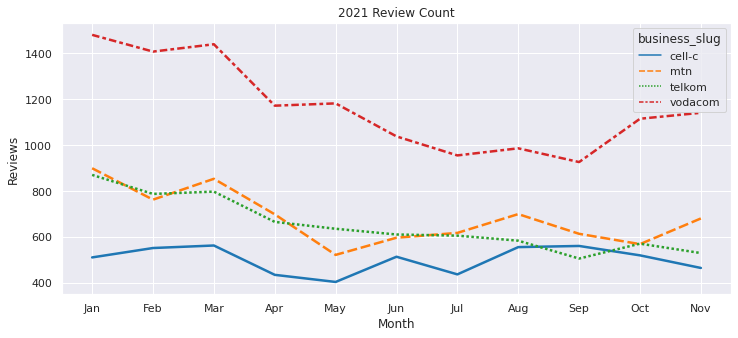

In [46]:
review_count_plot = sns.lineplot(
    data=df_grouped_month,
    x='month',
    y='counts',
    hue='business_slug',
    style='business_slug',
    palette="tab10", 
    linewidth=2.5)

review_count_plot.set(
    title='2021 Review Count',
    xlabel='Month',
    ylabel='Reviews'
)

[Text(0.5, 1.0, '2021 Ratings'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'Rating')]

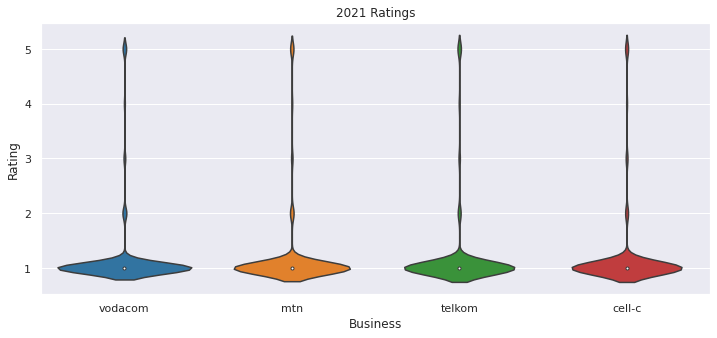

In [49]:
rating_plot = sns.violinplot(
    data=df_eda,
    x="business_slug", 
    y="review_rating",
    palette="tab10")

rating_plot.set(
    title='2021 Ratings',
    xlabel='Business',
    ylabel='Rating'
)    

[Text(0.5, 1.0, '2021 NPS Scores'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'NPS')]

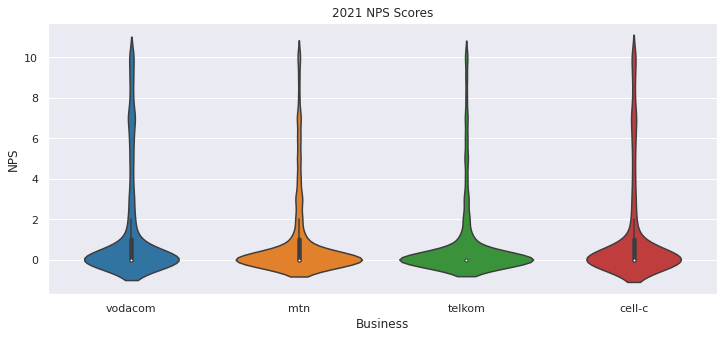

In [58]:
nps_plot = sns.violinplot(
    data=df_eda,
    x="business_slug", 
    y="nps_rating",
    palette="tab10")

nps_plot.set(
    title='2021 NPS Scores',
    xlabel='Business',
    ylabel='NPS'
)    

## References

<a name='hellopeter_nps'></a>[1] “Your Net Promoter Score - Hellopeter Blog.” https://blog.hellopeter.com/faqs/your-net-promoter-score (accessed Dec. 23, 2021).

<a name="telecom_size"></a>[2] “Vodacom vs MTN vs Telkom vs Cell C – how much money mobile networks make per subscriber in South Africa,” BusinessTech, Nov. 17, 2021. https://businesstech.co.za/news/mobile/537492/vodacom-vs-mtn-vs-telkom-vs-cell-c-how-much-money-mobile-networks-make-per-subscriber-in-south-africa/ (accessed Dec. 25, 2021).